In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer

In [2]:
torch.cuda.is_available()

True

In [3]:
classes = ['asphalt', 'tile', 'snowy_dirt', 'snow', 'dirty_tile', 'icy_tile']

MetadataCatalog.get("category").set(thing_classes=classes, thing_colors = [
        (255,255,0),(0,0,255),(0,255,0),(255,0,255), (180,165,0), (187,132,156)]) #Done by me
  
    

microcontroller_metadata = MetadataCatalog.get("category")

In [4]:
cfg_instance_seg = get_cfg()
cfg_instance_seg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_instance_seg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
cfg_instance_seg.MODEL.WEIGHTS = os.path.join("output", "model_final.pth")
cfg_instance_seg.MODEL.ROI_HEADS.NUM_CLASSES = 6
predictor = DefaultPredictor(cfg_instance_seg)

[11/26 15:06:32 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [5]:
class MyVisualizer(Visualizer):
    def _jitter(self, color ):
        return color

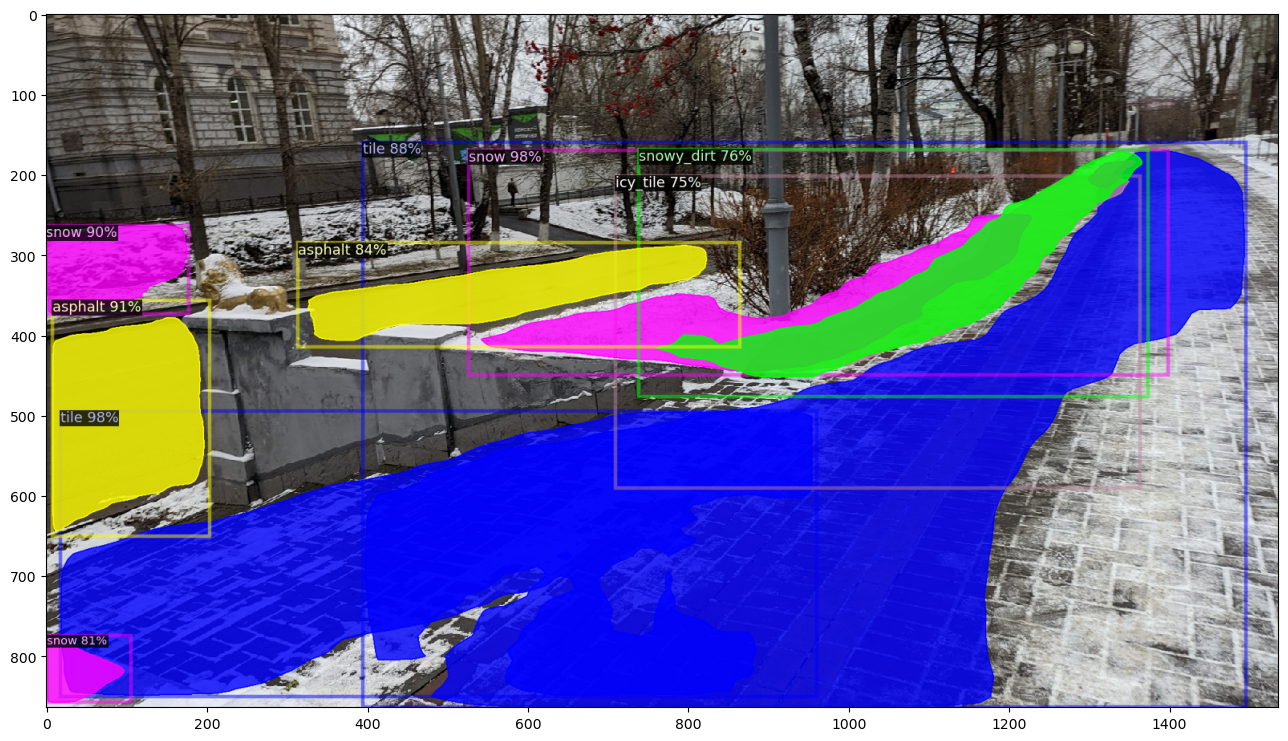

In [6]:
img = cv2.imread('DATA/test/176.jpg')
outputs = predictor(img)
v = MyVisualizer(img[:, :, ::-1],
                metadata=microcontroller_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.SEGMENTATION, # removes the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (16, 9))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
cap = cv2.VideoCapture("DATA/test/PXL_20221116_081947143.mp4")
result = cv2.VideoWriter('final_one.avi', -1, 20.0, (1920, 1080))
while(cap.isOpened()):
    success, img = cap.read()
    if success == True:
        img = cv2.resize(img, (1920, 1080), interpolation = cv2.INTER_AREA)
        outputs = predictor(img)
        v = MyVisualizer(img[:, :, ::-1],
                        metadata=microcontroller_metadata, 
                        scale=0.8, 
                        instance_mode=ColorMode.SEGMENTATION, # removes the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2.imshow("Image!", v.get_image()[:, :, ::-1])
        result.write(v.get_image()[:, :, ::-1])
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
    else:
        break
    
result.release()
cap.release()
cv2.destroyAllWindows()
print("Done, Don!")

Done, Don!
